In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
from cv2 import cv2
import os
from pathlib import Path

In [26]:
TRAIN_DF = '../data/input/train.csv'
VAL_DF = '../data/input/val.csv'
TEST_DF = '../data/input/test.csv'

MODEL_PATH = '../data/output/models/fashionnet/'
LOGGER_PATH = '../data/output/logs/fashionnet/'


train_df = pd.read_csv(TRAIN_DF).fillna(0)
val_df = pd.read_csv(VAL_DF).fillna(0)
test_df = pd.read_csv(TEST_DF).fillna(0)


image_shape = (224, 224, 3)  # all images will be adjusted to this shape
num_category = 23  # all images belong to 23 category
num_attr = 463  # each image has 463 attribute 
num_landmark_visibility = 3  # landmark has 3 status: visible, unvisible, unsure

train_df.head()

,image_name,item_id,landmark_visibility_1,landmark_location_x_1,landmark_location_y_1,landmark_visibility_2,landmark_location_x_2,landmark_location_y_2,landmark_visibility_3,landmark_location_x_3,...,landmark_location_x_6,landmark_location_y_6,landmark_visibility_7,landmark_location_x_7,landmark_location_y_7,landmark_visibility_8,landmark_location_x_8,landmark_location_y_8,attribute_labels,category_label
0,img/WOMEN/Dresses/id_00000002/02_1_front.jpg,id_00000002,1,109,63,0,156,70,0,94,...,161.0,136.0,0.0,89.0,234.0,0.0,206.0,230.0,0 2 5 6 9 11 13 14 15 22 26 52 85 92 143 161 1...,12
1,img/WOMEN/Dresses/id_00000002/02_2_side.jpg,id_00000002,1,127,59,0,145,61,1,121,...,141.0,125.0,1.0,123.0,217.0,0.0,132.0,229.0,0 2 5 6 9 11 13 14 15 22 26 52 85 92 143 161 1...,12
2,img/WOMEN/Dresses/id_00000002/02_4_full.jpg,id_00000002,0,123,46,0,148,51,0,108,...,149.0,96.0,0.0,101.0,149.0,0.0,157.0,156.0,0 2 5 6 9 11 13 14 15 22 26 52 85 92 143 161 1...,12
3,img/WOMEN/Dresses/id_00000002/02_7_additional.jpg,id_00000002,0,153,58,0,112,61,0,172,...,108.0,141.0,0.0,175.0,228.0,0.0,91.0,233.0,0 2 5 6 9 11 13 14 15 22 26 52 85 92 143 161 1...,12
4,img/WOMEN/Skirts/id_00000003/02_1_front.jpg,id_00000003,1,79,131,1,125,130,0,67,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0 1 2 6 12 13 20 23 42 55 84 87 113 152 171 19...,19


In [187]:
def expand_path(p, **kwargs):
    """read the complete path
    
    Arguments
        p: the string of path that save in csv files, such as `img/MEN/Denim/id_00000080/01_1_front.jpg`
        
    Return:
        the complete path, such as `../data/input/Img/img/MEN/Denim/id_00000080/01_1_front.jpg`
    """
    header = Path('../data/input/Img/')
    return str(header / p)


def read_raw_image(p, **kwargs):
    """read image from disk
    
    Arguments
        p: the string of path that save in csv files, such as `img/MEN/Denim/id_00000080/01_1_front.jpg`
    
    Return
        The pil image object
    """
    img = Image.open(expand_path(p))
#     img = cv2.imread(expand_path(p), 1)
    return img
def show_img(imgs, per_row=2, rescale=False,landmarks_x=[],landmarks_y=[],landmarks_v=[]):
    """show images in cell's output
    
    Arguments
        imgs: a list of np.ndarray or pil.Image.Image, the length of imgs should no less than 2
        per_row: how manny images are showed per row
        rescale: if the images have been rescale into 0~1, then the rescale should be True
    
    Return
        None       
    """
    images = []
    for i in range(len(imgs)):
        if isinstance(imgs[i], np.ndarray):
            if rescale:
                mm, mn = imgs[i].max(), imgs[i].min()
                scale = 255 / (mm-mn)
                imgs[i] += mn
                imgs[i] *= scale
            images.append(Image.fromarray(np.uint8(imgs[i])))
        else:
            images.append(imgs[i])
    imgs = images
    n = len(imgs)
    rows = (n + per_row - 1) // per_row
    cols = min(per_row, n)
    fig, axes = plt.subplots(rows, cols, figsize=(24 // per_row * cols, 24 // per_row * rows))
#     for ax in axes.flatten(): 
#         ax.axis('off')
    for i, (img, ax) in enumerate(zip(imgs, axes.flatten())):
        # 使用红色星状物标记绘制点
        for j in range(8):
            if landmarks_v[i][j] < 1 and landmarks_x[i][j] > 0 and landmarks_y[i][j] > 0 : 
                ax.plot(landmarks_x[i][j],landmarks_y[i][j],'r*')
        ax.imshow(img.convert('RGB'))

In [237]:
dataF = train_df[train_df['item_id']=='id_00001723']
# dataF = [dataF.iloc[:,2+i*3]  for i in range(8)]
# print(type(dataF),len(dataF[0]))


img/MEN/Shirts_Polos/id_00001723/04_1_front.jpg


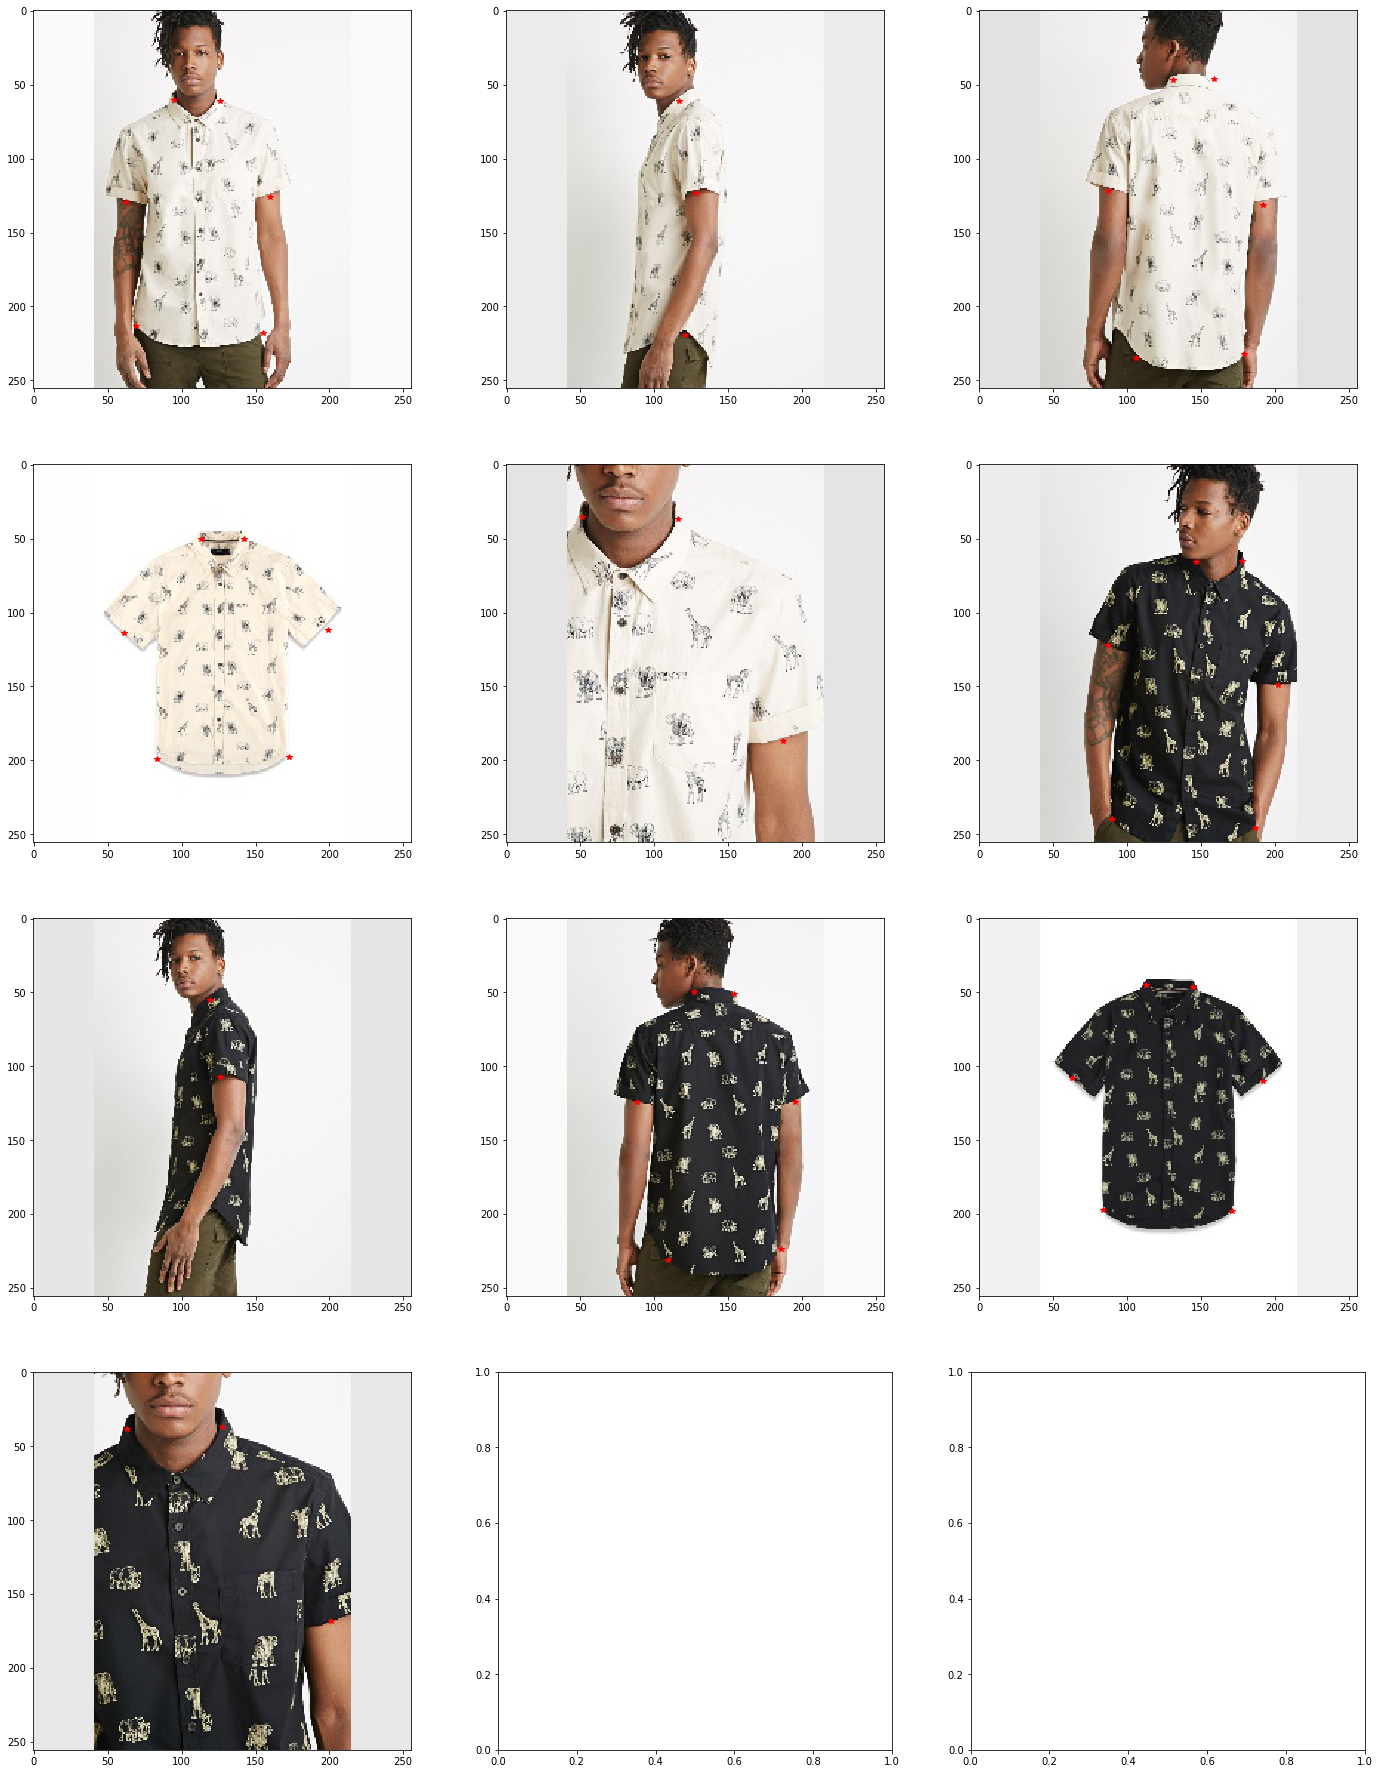

In [253]:
# show 3 of the images in the train_df
imgs = []
l_v0 = [dataF.iloc[:,2+i*3]  for i in range(8)]
l_x0 = [dataF.iloc[:,3+i*3]  for i in range(8)]
l_y0 = [dataF.iloc[:,4+i*3]  for i in range(8)]
l_v1=[]
l_x1=[]
l_y1=[]
# print(type(l_x0[0]))
# print(type(l_v0[7]),l_v0[7].iloc[9])
for j in range(10):
    v = [l_v0[i].iloc[j] for i in range(8)]
    x = [l_x0[i].iloc[j] for i in range(8)]
    y = [l_y0[i].iloc[j] for i in range(8)]
    l_v1.append(v)
    l_x1.append(x)
    l_y1.append(y)
l_v1 = np.array(l_v1,dtype = np.int32)
l_x1 = np.array(l_x1,dtype = np.int32)
l_y1 = np.array(l_y1,dtype = np.int32)
# print(l_v1)
print(dataF.iloc[:,0].iloc[0])
for i in range(len(dataF.iloc[:,0])):
    img_name = dataF.iloc[:,0].iloc[i]
    im = read_raw_image(img_name)
    imgs.append(im)
    if len(imgs) == 10:    
        break
show_img(imgs, 3,landmarks_x = l_x1,landmarks_y=l_y1,landmarks_v=l_v1)